# 2.1. Деревья решений. Классификация

### Agenda:
* критерий информативности
* визуализация разделяющих поверхностей решения и визуализация самого дерева
* оценка важности фичей
* ужасы переобучения

## 1. Критерий информативности

как мы разобрали, построение дерева зависит от следующих факторов:
* вид правила разбиения
* критерий информативности
* критерий останова
* метод стрижки
* проблема пропусков

пройдёмся критериям информативности

In [2]:
import numpy as np
from collections import Counter

*Нам понадобятся две библиотеки: numpy вы знаете, а объект класса Counter в заданном списке просто подсчитывает количество вхождений каждого элемента и возвращает результат в виде словаря. Пример:*

In [3]:
x = Counter([9,9,9,7,7])
x

Counter({9: 3, 7: 2})

In [4]:
x[9]

3

*Для численного измерения улучшения разбиений на каждом этапе мы вводим некоторый *критерий информативности*, который будет оценивать разнообразие объектов в выборке: чем больше разных классов в выборке, тем больше значение H(R). Чем меньше взвешенное значение критерия после разбиения - тем лучше*

Ниже представлена функция для расчёта энтропийного критерия качества:

$H(R) = -\sum_{k=1}^{K}p_klogp_k$

 ### **Задание.** Дополните функцию расчёта энтропийного критерия множества

In [11]:
def HEntropy(l):
    length = len(l)
    cnt = Counter(l)
    H = 0
    for val in cnt.values():
        p = val / length
        H -= p * np.log(p) 
    return H

In [13]:
HEntropy([9,9,9,7,7])

0.6730116670092565

**Задание.** По аналогии с *энтропийным критерием* заполните функции *критерия Джини*

$Н(R) = -\sum_{k=1}^{K}p_k(1-p_k)$

In [16]:
def HGini(l):
    length = len(l)
    cnt = Counter(l)
    H = 0
    for val in cnt.values():
        p = val / length
        H += p * (1 - p) 
    return H

In [19]:
HGini([2,2,2,7,7,7])

0.5

###  Information Gain
*Information Gain (IG)* - функционал качества, отвечающий на вопрос, а сколько энтропии мы погасили при определённом разбиении? На каждом шаге разбиения при построении дерева максимизируется IG. Формула для вычисления при критерии информативности H:

$IG(R) = H(R) - \frac{|R_l|}{|R|}H(R_l) - \frac{|R_r|}{|R|}H(R_r)$

### **Задание.** Заполните функцию для вычисления функционала качества

In [25]:
def IG(H, l, r):
    ql = len(l)
    qr = len(r)
    return H(l+r) - (ql / (ql + qr)) * H(l) - (qr / (ql + qr)) * H(r)    

In [26]:
IG(HGini, [2,2,2], [7,7,7])

0.5

### Тут функция для визуализации работы произвольного критерия качества на выборке

In [27]:
def test_H(H, l):
    print("{:5} {:3}   {:4} {:4} {:4}".format("#","l","IG","Hl","Hr"))
    print("-"*24)
    for i in range(1, len(l)):
        print("{:2}. {:3}   {:.2f} {:.2f} {:.2f}".format(i, l[i], IG(H, l, i), H(l[:i]), H(l[i:])))

Определим как-нибудь выборку и посмотрим, какое разбиение предложат критерии информативности. Замечу, что элементы здесь будут выводиться начиная со второго, а значения функций рассчитаны для разбиения *перед* элементом строки

In [28]:
l = [1]*5 + [2]*3 + [1]*4
print(l)

[1, 1, 1, 1, 1, 2, 2, 2, 1, 1, 1, 1]


In [84]:
# test_H(HEntropy, l)

In [85]:
# test_H(HGini, l)

## 2. Визуализация принятия решений классификатором sklearn

#### 1. Используем данные о цветках ириса из занятия

In [30]:
from sklearn.datasets import load_iris
import pandas as pd

In [31]:
from matplotlib import pyplot as plt
%matplotlib inline
import seaborn as sns

In [32]:
iris = load_iris()

In [33]:
X = pd.DataFrame(iris.data, columns=iris.feature_names)
y = pd.DataFrame(iris.target, columns=['species'])
df = pd.concat([X,y], axis=1)

In [34]:
print(df.shape)
df.head()

(150, 5)


,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),species
0,5.1,3.5,1.4,0.2,0
1,4.9,3.0,1.4,0.2,0
2,4.7,3.2,1.3,0.2,0
3,4.6,3.1,1.5,0.2,0
4,5.0,3.6,1.4,0.2,0


Выведем попарное распределение фичей датасета с раскраской по виду цветка

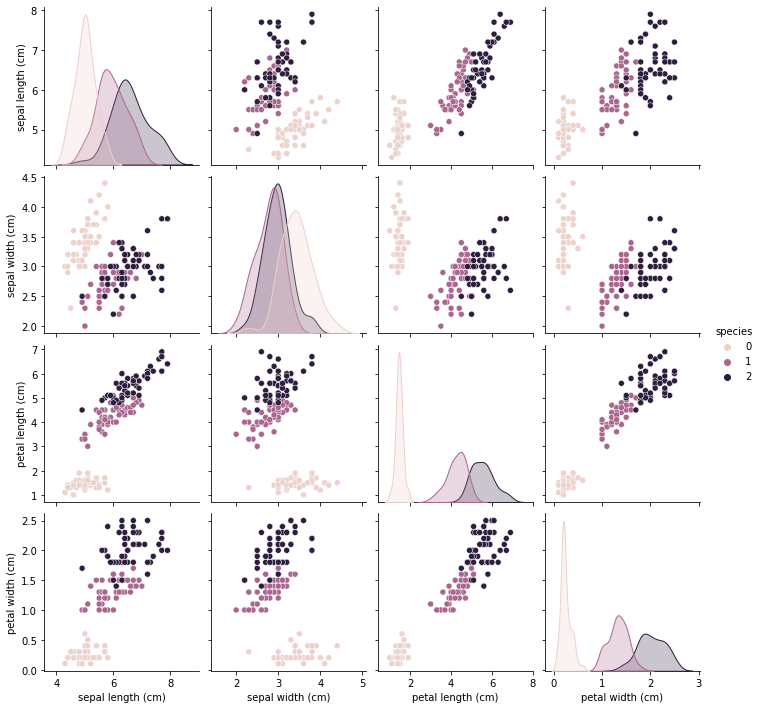

In [35]:
sns.pairplot(df, hue='species', diag_kind="kde")

Визуально кажется, что ширина листка (petal width) может самостоятельно отделить два класса друг от друга идеально. Для других двух классов понадобится еще хотя бы ещё одна фича.

Возьмём две фичи для возможности изобразить это в 2D: 
длину и ширину листка

In [36]:
Xcut = X[X.columns[2:4]]

#### 2. Используем классификатор

In [37]:
from sklearn.tree import DecisionTreeClassifier

In [38]:
# DecisionTreeClassifier?

In [39]:
clf = DecisionTreeClassifier(max_depth=2)

In [40]:
clf.fit(Xcut, y)

DecisionTreeClassifier(max_depth=2)

In [41]:
clf.predict([ [1,1], [3,3] ])

array([1, 2])

In [42]:
df.species.unique()

array([0, 1, 2])

In [43]:
clf.predict_proba([ [1,1], [3,3] ])

array([[0.        , 0.90740741, 0.09259259],
       [0.        , 0.02173913, 0.97826087]])

Визуализируем границу принятия решений. Для удобства все упаковано в функцию **test_clf**, в неё передаётся созданный классификатор и при установленном fit_clf=True обучается внутри, а затем отрисовывает границу. Таким образом можно экспериментировать с параметрами классификатора

In [44]:
def get_grid(data):
    x_min, x_max = data[:, 0].min() - 1, data[:, 0].max() + 1
    y_min, y_max = data[:, 1].min() - 1, data[:, 1].max() + 1
    return np.meshgrid(np.arange(x_min, x_max, 0.01), np.arange(y_min, y_max, 0.01))

In [45]:
def test_clf(clf, X, y,cy=0, fit_clf=False):
    xx,yy = get_grid(X.values)
    if fit_clf:
        clf.fit(X, y)
    predicted = clf.predict(np.c_[xx.ravel(), yy.ravel()]).reshape(xx.shape)
    plt.figure(figsize=(8, 8))
    plt.pcolormesh(xx, yy, predicted, cmap='Pastel1')
    plt.scatter(X.values[:, 0], X.values[:, 1], s=100, cmap='tab10',c=cy)
    if fit_clf:
        return clf

*попробуйте при разной глубине*

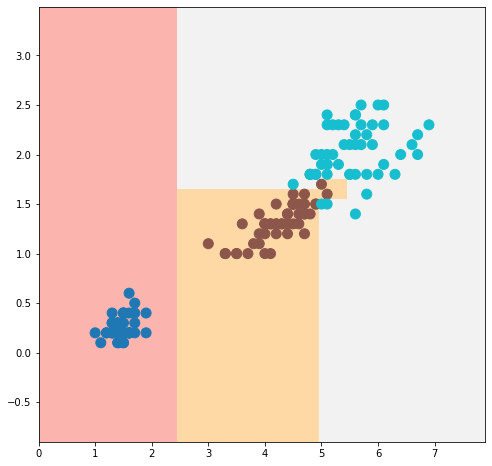

In [52]:
clf = test_clf(DecisionTreeClassifier(max_depth=7), Xcut, y,cy=y['species'].tolist(), fit_clf=True)

обратите внимание, один блок занимает то позицию снизу, то слева: данных недостаточно для принятия однозначного решения и экстраполяция идёт произвольно

#### 3. Визуализируем само дерево

Возможно, самое замечательное свойство одиночных деревьев - возможность визуализировать их алгоритм работы и затем объяснить его хоть человеку, хоть машине

Дерево можно как-то отобразить внутри ipython-ноутбука с помощью библиотеки pydot и установлнного webgraphviz, но мы воспользуемся скорее онлайн-сервисом http://www.webgraphviz.com

Сгенерируем код дерева в формате .dot и скопируем его на сайт

In [53]:
from sklearn.tree import export_graphviz

def get_tree_dot_view(clf, feature_names=None, class_names=None):
    print(export_graphviz(clf, out_file=None, filled=True, feature_names=feature_names, class_names=class_names))

In [54]:
clf = DecisionTreeClassifier(max_depth=3)
clf.fit(Xcut, y)

DecisionTreeClassifier(max_depth=3)

In [55]:
clf.feature_importances_

array([0.05393633, 0.94606367])

In [83]:
# # from sklearn.externals.six import StringIO  
# from six import StringIO
# from IPython.display import Image  
# from sklearn.tree import export_graphviz
# # import pydotplus
# dot_data = StringIO()
# export_graphviz(clf, out_file=dot_data,  
#                 filled=True, rounded=True,
#                 special_characters=True)
# graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
# Image(graph.create_png())

In [57]:
get_tree_dot_view(clf, list(Xcut.columns), iris.target_names)

digraph Tree {
node [shape=box, style="filled", color="black"] ;
0 [label="petal width (cm) <= 0.8\ngini = 0.667\nsamples = 150\nvalue = [50, 50, 50]\nclass = setosa", fillcolor="#ffffff"] ;
1 [label="gini = 0.0\nsamples = 50\nvalue = [50, 0, 0]\nclass = setosa", fillcolor="#e58139"] ;
0 -> 1 [labeldistance=2.5, labelangle=45, headlabel="True"] ;
2 [label="petal width (cm) <= 1.75\ngini = 0.5\nsamples = 100\nvalue = [0, 50, 50]\nclass = versicolor", fillcolor="#ffffff"] ;
0 -> 2 [labeldistance=2.5, labelangle=-45, headlabel="False"] ;
3 [label="petal length (cm) <= 4.95\ngini = 0.168\nsamples = 54\nvalue = [0, 49, 5]\nclass = versicolor", fillcolor="#4de88e"] ;
2 -> 3 ;
4 [label="gini = 0.041\nsamples = 48\nvalue = [0, 47, 1]\nclass = versicolor", fillcolor="#3de684"] ;
3 -> 4 ;
5 [label="gini = 0.444\nsamples = 6\nvalue = [0, 2, 4]\nclass = virginica", fillcolor="#c09cf2"] ;
3 -> 5 ;
6 [label="petal length (cm) <= 4.85\ngini = 0.043\nsamples = 46\nvalue = [0, 1, 45]\nclass = virginica

-----

**Задание**
1. визуализировать дерево
2. вставить скрин с картинкой сюда в ipython notebook (!\[text](imagename.png))
3. проверить индексы Джини в узлах: совпадают с нашей расчётной функцией?
4. ветка налево - это True или False? что значит цвет узла? class? values?

![title](tree.png)

In [87]:
HGini([50,50,50])

0.0

In [88]:
HGini([0,50,50])

0.4444444444444445

In [89]:
HGini([0,1,45])

0.6666666666666667

## 3. Оценка важности фичей

важность зависит от конкретного прогона классификатора, это не объективный показатель, но дающий представление

*попробуйте при разной глубине*

''

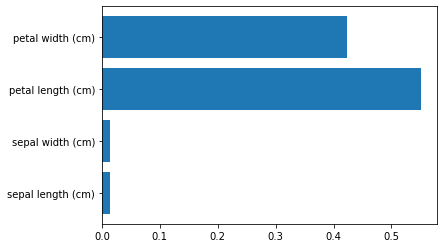

In [70]:
clf = DecisionTreeClassifier(max_depth=6)
clf.fit(X, y)

plt.barh(np.arange(len(clf.feature_importances_)), clf.feature_importances_)
plt.yticks(np.arange(len(X.columns)), X.columns)
''

## 4. Переообучение наглядно

*здесь я использую генерацию датасета из [блога](https://habrahabr.ru/company/ods/blog/322534/) open data science*

In [71]:
np.seed = 7
train_data = np.random.normal(size=(100, 2))
train_labels = np.zeros(100)
train_data = np.r_[train_data, np.random.normal(size=(100, 2), loc=2)]
train_labels = np.r_[train_labels, np.ones(100)]
train_data = pd.DataFrame(train_data)

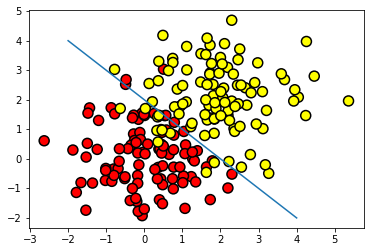

In [73]:
plt.scatter(train_data[0], train_data[1], c=train_labels, s=100, cmap='autumn', edgecolors='black', linewidth=1.5);
plt.plot(range(-2,5), range(4,-3,-1));

*попробуйте при разной глубине*

In [74]:
train_labels

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])

ValueError: 'c' argument has 150 elements, which is inconsistent with 'x' and 'y' with size 200.

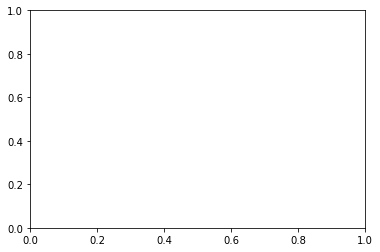

In [75]:
plt.scatter(train_data.values[:, 0], train_data.values[:, 1], s=100, cmap='tab10', c=y['species'].tolist())

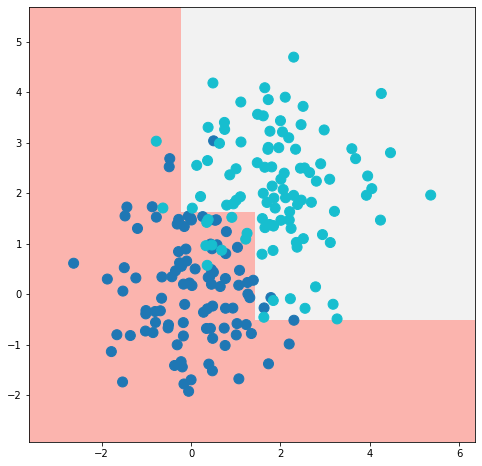

In [78]:
clf = test_clf(DecisionTreeClassifier(max_depth=3), train_data, train_labels,cy=train_labels, fit_clf=True)

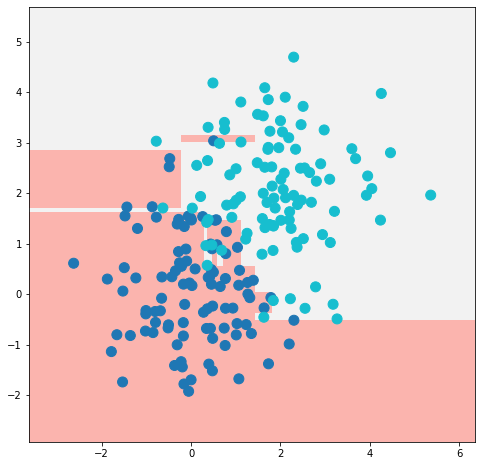

In [79]:
clf = test_clf(DecisionTreeClassifier(), train_data, train_labels,cy=train_labels, fit_clf=True)

А здесь можно увидеть огромное переобученное дерево: http://www.webgraphviz.com

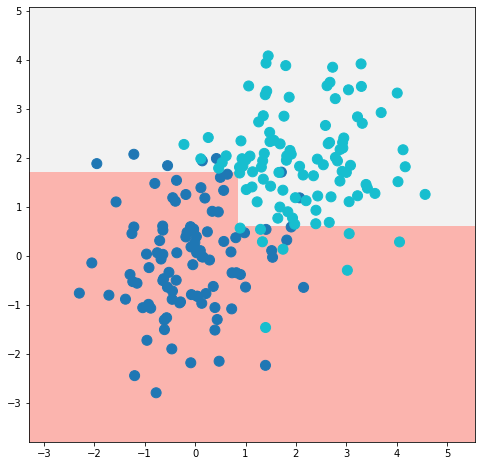

In [ ]:
clf = test_clf(DecisionTreeClassifier(max_depth=2), train_data, train_labels,cy=train_labels, fit_clf=True)

digraph Tree {
node [shape=box, style="filled", color="black"] ;
0 [label="x <= 1.436\ngini = 0.5\nsamples = 200\nvalue = [100, 100]", fillcolor="#ffffff"] ;
1 [label="y <= 1.625\ngini = 0.352\nsamples = 123\nvalue = [95, 28]", fillcolor="#eda673"] ;
0 -> 1 [labeldistance=2.5, labelangle=45, headlabel="True"] ;
2 [label="y <= 0.561\ngini = 0.165\nsamples = 99\nvalue = [90, 9]", fillcolor="#e88e4d"] ;
1 -> 2 ;
3 [label="gini = 0.0\nsamples = 66\nvalue = [66, 0]", fillcolor="#e58139"] ;
2 -> 3 ;
4 [label="x <= 0.296\ngini = 0.397\nsamples = 33\nvalue = [24, 9]", fillcolor="#efb083"] ;
2 -> 4 ;
5 [label="gini = 0.0\nsamples = 15\nvalue = [15, 0]", fillcolor="#e58139"] ;
4 -> 5 ;
6 [label="x <= 0.367\ngini = 0.5\nsamples = 18\nvalue = [9, 9]", fillcolor="#ffffff"] ;
4 -> 6 ;
7 [label="gini = 0.0\nsamples = 3\nvalue = [0, 3]", fillcolor="#399de5"] ;
6 -> 7 ;
8 [label="x <= 1.13\ngini = 0.48\nsamples = 15\nvalue = [9, 6]", fillcolor="#f6d5bd"] ;
6 -> 8 ;
9 [label="y <= 1.474\ngini = 0.426\ns

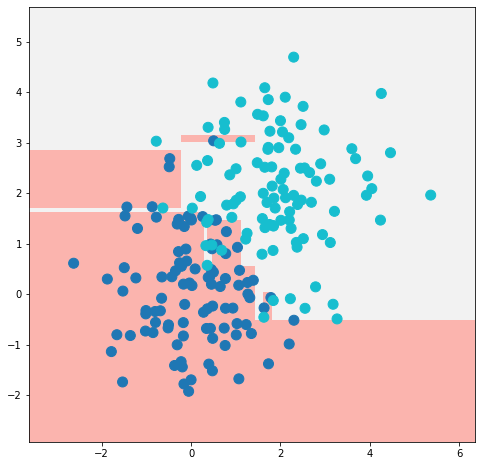

In [80]:
clf = test_clf(DecisionTreeClassifier(max_depth=10), train_data, train_labels,cy=train_labels, fit_clf=True)
get_tree_dot_view(clf, feature_names=['x','y'])

# Домашнее задание «Деревья решений»
Для выполнения домашнего задания необходимо взять файл boston house-prices datase (sklearn.datasets.load_boston) и построить модель.

По аналогии задания к лекции «Классификация: Логистическая регрессия и SVM».

А именно построить модель регрессии, дерево решений, оптимизировать параметры и сравнить результаты.

In [113]:
from sklearn.datasets import load_boston
import pandas as pd
import seaborn as sns
#увеличим дефолтный размер графиков
from pylab import rcParams
rcParams['figure.figsize'] = 13,6
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split

In [91]:
data = load_boston()
X = pd.DataFrame(data['data'], columns=data['feature_names'])
y = pd.DataFrame(data['target'], columns=['MEDV'])
df = pd.concat([X,y], axis=1)
df.head()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,MEDV
0,0.00632,18.0,2.31,0.0,0.538,6.575,65.2,4.0900,1.0,296.0,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0.0,0.469,6.421,78.9,4.9671,2.0,242.0,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0.0,0.469,7.185,61.1,4.9671,2.0,242.0,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0.0,0.458,6.998,45.8,6.0622,3.0,222.0,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0.0,0.458,7.147,54.2,6.0622,3.0,222.0,18.7,396.90,5.33,36.2


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)  

In [129]:
clf = RandomForestRegressor(max_depth=10)

In [130]:
# clf.fit(X, data['target'])
clf.fit(X_train, np.ravel(y_train))

RandomForestRegressor(max_depth=10)

In [131]:
clf.score(X_test, y_test)

0.8044477132447868

In [132]:
clf.feature_importances_

array([0.03784645, 0.00132502, 0.00795524, 0.0025432 , 0.01353439,
       0.44723005, 0.01151734, 0.03392245, 0.00422144, 0.01658508,
       0.01968308, 0.01021665, 0.39341963])

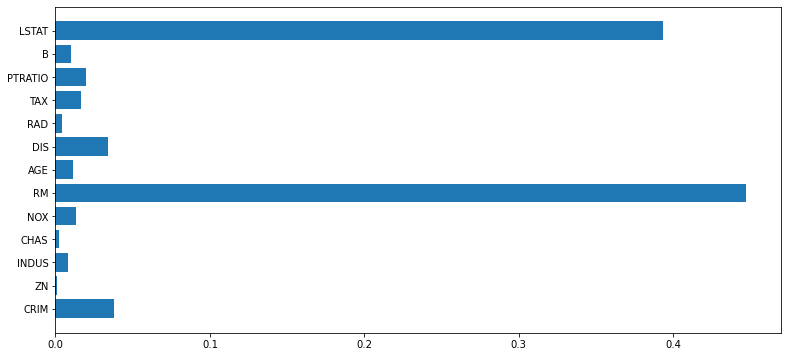

In [133]:
plt.barh(np.arange(len(clf.feature_importances_)), clf.feature_importances_);
plt.yticks(np.arange(len(X.columns)), X.columns);

In [115]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)  

In [116]:
model = LinearRegression() 
model.fit(X_train, y_train)

LinearRegression()

In [117]:
model.score(X_test, y_test)

0.6733825506400177